In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
USE_CUDA = torch.cuda.is_available() 
device = torch.device("cuda" if USE_CUDA else "cpu") 
print("device", device)

device cpu


In [2]:
class bnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 10
        self.tanh = nn.Tanh()
        
        self.w1 = nn.Parameter(
            torch.zeros(2, self.hidden_size, dtype = torch.float32, requires_grad=True)
        )
        self.b = nn.Parameter(
            torch.zeros(self.hidden_size, dtype = torch.float32,requires_grad=True)
        )
        self.w2 = nn.Parameter(
            torch.zeros(self.hidden_size, 1, dtype = torch.float32, requires_grad=True)
        )
        
        
    def rep(self, mu):
        return mu + torch.randn_like(mu)

    def forward(self, x, batch_size):
        b = self.rep(self.b)
        w1 = self.rep(self.w1)
        w2 = self.rep(self.w2)
        b = b.expand(batch_size, self.hidden_size)
        x = torch.matmul(x, w1) + b
        x = self.tanh(x)
        x = torch.matmul(x, w2)
        return x, w1, w2, b
    
    def kldloss(self, w1, w2, b):
        sum1 = torch.sum(torch.square(self.w1 - w1))
        sum2 = torch.sum(torch.square(self.w2 - w2))
        sum3 = torch.sum(torch.square(self.b - b))
        return sum1 + sum2 + sum3
    
mybnn = bnn()



In [3]:
tmp_data = torch.tensor([[-1., 3., 5], [-2, 2, 5], [-0.5, 2, 4], 
                         [-0.5, 1.5, 3], [0.5, 1, 1], [1, 1, -1],
                         [2, 2, -3], [3, 2, -4], [4, 4, -5],
                         [5, 4, -4], [5, 5, -3], [6, 4, -2],
                         [7, 4, -1], [8, 3, 0], [8, 4, 1],
                         [9, 3, 3], [9, 1, 5], [10, 2, 6]])
batch_size = 3
hidden_size = 10

w1 = torch.zeros(2, hidden_size)
b = torch.zeros(hidden_size)
w2 = torch.zeros(hidden_size, 1)



In [4]:
train_dataloader = DataLoader(tmp_data, batch_size=3, shuffle=True)
optimizer = torch.optim.SGD(mybnn.parameters(), lr=0.000001)



In [5]:
i = 0
while i < 1000:
    train_data = next(iter(train_dataloader))
    newdata = torch.split(train_data, 2, dim = 1)
    output = mybnn(newdata[0],batch_size)
    likelihood = torch.sum(torch.square(newdata[1] - output[0]))
    loss = likelihood + mybnn.kldloss(w1,w2,b)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    i = i + 1

tensor(4.2120, grad_fn=<AddBackward0>)
tensor(46.1559, grad_fn=<AddBackward0>)
tensor(111.8355, grad_fn=<AddBackward0>)
tensor(30.6414, grad_fn=<AddBackward0>)
tensor(34.2900, grad_fn=<AddBackward0>)
tensor(140.2881, grad_fn=<AddBackward0>)
tensor(33.6269, grad_fn=<AddBackward0>)
tensor(16.0334, grad_fn=<AddBackward0>)
tensor(23.7793, grad_fn=<AddBackward0>)
tensor(56.1195, grad_fn=<AddBackward0>)
tensor(11.4267, grad_fn=<AddBackward0>)
tensor(52.4567, grad_fn=<AddBackward0>)
tensor(5.2148, grad_fn=<AddBackward0>)
tensor(50.4427, grad_fn=<AddBackward0>)
tensor(23.3874, grad_fn=<AddBackward0>)
tensor(39.7907, grad_fn=<AddBackward0>)
tensor(105.2244, grad_fn=<AddBackward0>)
tensor(59.4476, grad_fn=<AddBackward0>)
tensor(8.1684, grad_fn=<AddBackward0>)
tensor(75.2014, grad_fn=<AddBackward0>)
tensor(13.3488, grad_fn=<AddBackward0>)
tensor(5.0623, grad_fn=<AddBackward0>)
tensor(57.3881, grad_fn=<AddBackward0>)
tensor(4.6366, grad_fn=<AddBackward0>)
tensor(27.0816, grad_fn=<AddBackward0>)
te

tensor(130.6880, grad_fn=<AddBackward0>)
tensor(35.5227, grad_fn=<AddBackward0>)
tensor(71.8836, grad_fn=<AddBackward0>)
tensor(243.4403, grad_fn=<AddBackward0>)
tensor(20.1318, grad_fn=<AddBackward0>)
tensor(117.2965, grad_fn=<AddBackward0>)
tensor(55.9516, grad_fn=<AddBackward0>)
tensor(85.6067, grad_fn=<AddBackward0>)
tensor(9.8047, grad_fn=<AddBackward0>)
tensor(144.8129, grad_fn=<AddBackward0>)
tensor(11.1797, grad_fn=<AddBackward0>)
tensor(62.1029, grad_fn=<AddBackward0>)
tensor(22.3064, grad_fn=<AddBackward0>)
tensor(13.7886, grad_fn=<AddBackward0>)
tensor(104.6961, grad_fn=<AddBackward0>)
tensor(21.2965, grad_fn=<AddBackward0>)
tensor(28.4804, grad_fn=<AddBackward0>)
tensor(113.0983, grad_fn=<AddBackward0>)
tensor(134.2422, grad_fn=<AddBackward0>)
tensor(93.3809, grad_fn=<AddBackward0>)
tensor(42.8369, grad_fn=<AddBackward0>)
tensor(114.3289, grad_fn=<AddBackward0>)
tensor(8.3376, grad_fn=<AddBackward0>)
tensor(170.1827, grad_fn=<AddBackward0>)
tensor(98.7505, grad_fn=<AddBackw

tensor(62.2778, grad_fn=<AddBackward0>)
tensor(82.3797, grad_fn=<AddBackward0>)
tensor(21.0910, grad_fn=<AddBackward0>)
tensor(278.9490, grad_fn=<AddBackward0>)
tensor(43.2678, grad_fn=<AddBackward0>)
tensor(57.1279, grad_fn=<AddBackward0>)
tensor(53.1871, grad_fn=<AddBackward0>)
tensor(53.3927, grad_fn=<AddBackward0>)
tensor(26.7301, grad_fn=<AddBackward0>)
tensor(2.4933, grad_fn=<AddBackward0>)
tensor(44.1522, grad_fn=<AddBackward0>)
tensor(24.6325, grad_fn=<AddBackward0>)
tensor(61.4778, grad_fn=<AddBackward0>)
tensor(17.5948, grad_fn=<AddBackward0>)
tensor(55.1630, grad_fn=<AddBackward0>)
tensor(4.8230, grad_fn=<AddBackward0>)
tensor(15.8051, grad_fn=<AddBackward0>)
tensor(56.6185, grad_fn=<AddBackward0>)
tensor(41.6226, grad_fn=<AddBackward0>)
tensor(55.2508, grad_fn=<AddBackward0>)
tensor(7.5909, grad_fn=<AddBackward0>)
tensor(49.3788, grad_fn=<AddBackward0>)
tensor(61.3696, grad_fn=<AddBackward0>)
tensor(79.2150, grad_fn=<AddBackward0>)
tensor(92.7698, grad_fn=<AddBackward0>)
te

tensor(78.7925, grad_fn=<AddBackward0>)
tensor(14.5844, grad_fn=<AddBackward0>)
tensor(142.2838, grad_fn=<AddBackward0>)
tensor(61.4621, grad_fn=<AddBackward0>)
tensor(135.6170, grad_fn=<AddBackward0>)
tensor(187.0777, grad_fn=<AddBackward0>)
tensor(69.8678, grad_fn=<AddBackward0>)
tensor(10.8632, grad_fn=<AddBackward0>)
tensor(67.7211, grad_fn=<AddBackward0>)
tensor(53.0301, grad_fn=<AddBackward0>)
tensor(33.2770, grad_fn=<AddBackward0>)
tensor(29.9667, grad_fn=<AddBackward0>)
tensor(76.7818, grad_fn=<AddBackward0>)
tensor(81.4645, grad_fn=<AddBackward0>)
tensor(16.3549, grad_fn=<AddBackward0>)
tensor(36.4831, grad_fn=<AddBackward0>)
tensor(87.6185, grad_fn=<AddBackward0>)
tensor(97.6778, grad_fn=<AddBackward0>)
tensor(93.7846, grad_fn=<AddBackward0>)
tensor(60.6109, grad_fn=<AddBackward0>)
tensor(28.5690, grad_fn=<AddBackward0>)
tensor(86.5791, grad_fn=<AddBackward0>)
tensor(74.7257, grad_fn=<AddBackward0>)
tensor(54.5020, grad_fn=<AddBackward0>)
tensor(66.5628, grad_fn=<AddBackward0

tensor(49.2680, grad_fn=<AddBackward0>)
tensor(73.8909, grad_fn=<AddBackward0>)
tensor(50.8641, grad_fn=<AddBackward0>)
tensor(58.2319, grad_fn=<AddBackward0>)
tensor(42.2299, grad_fn=<AddBackward0>)
tensor(63.6444, grad_fn=<AddBackward0>)
tensor(65.6362, grad_fn=<AddBackward0>)
tensor(44.3839, grad_fn=<AddBackward0>)
tensor(65.4646, grad_fn=<AddBackward0>)
tensor(79.9230, grad_fn=<AddBackward0>)
tensor(3.1564, grad_fn=<AddBackward0>)
tensor(152.3144, grad_fn=<AddBackward0>)
tensor(126.9955, grad_fn=<AddBackward0>)
tensor(220.2939, grad_fn=<AddBackward0>)
tensor(34.5568, grad_fn=<AddBackward0>)
tensor(280.9208, grad_fn=<AddBackward0>)
tensor(12.6755, grad_fn=<AddBackward0>)
tensor(75.4409, grad_fn=<AddBackward0>)
tensor(196.6291, grad_fn=<AddBackward0>)
tensor(110.5870, grad_fn=<AddBackward0>)
tensor(80.5199, grad_fn=<AddBackward0>)
tensor(58.2547, grad_fn=<AddBackward0>)
tensor(17.2013, grad_fn=<AddBackward0>)
tensor(21.8580, grad_fn=<AddBackward0>)
tensor(40.2417, grad_fn=<AddBackwar

In [6]:
mybnn.w1

Parameter containing:
tensor([[-3.6244e-04,  9.7074e-04,  3.1464e-04,  1.1073e-03,  3.7059e-04,
          5.1250e-04, -3.4349e-05,  9.1262e-04, -8.2956e-04, -6.3392e-04],
        [-1.5517e-04,  3.0372e-04,  4.1845e-04,  2.9030e-04,  5.8176e-04,
          6.8116e-04,  2.9399e-04,  1.2578e-04, -4.7963e-04, -1.6867e-04]],
       requires_grad=True)

In [7]:
mybnn.b

Parameter containing:
tensor([-2.4246e-05,  2.5466e-04,  1.4481e-04,  8.1509e-05,  2.4228e-04,
         3.3644e-04,  1.6034e-04, -2.9703e-05, -2.7334e-04, -5.1192e-05],
       requires_grad=True)

In [8]:
mybnn.w2

Parameter containing:
tensor([[ 2.8468e-04],
        [-4.5922e-05],
        [ 2.9852e-04],
        [ 2.1274e-04],
        [ 4.9704e-04],
        [ 2.1488e-04],
        [ 1.8056e-04],
        [ 2.6077e-04],
        [ 1.7302e-04],
        [ 1.8377e-04]], requires_grad=True)

In [9]:
print(newdata[0])
mybnn(newdata[0],3)[0]

tensor([[-1.,  3.],
        [ 2.,  2.],
        [ 7.,  4.]])


tensor([[-2.1380],
        [-3.2902],
        [-1.6537]], grad_fn=<MmBackward>)

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

tensor([[ 2.3618],
        [-0.7324],
        [-2.9247],
        [-4.1043],
        [-4.4710],
        [-4.5680],
        [-4.5889],
        [-4.5813],
        [-4.5570],
        [-4.5192],
        [ 5.1950],
        [ 3.2846],
        [ 1.2039],
        [-1.1539],
        [-2.3640],
        [-2.7187],
        [-2.7788],
        [-2.7409],
        [-2.6626],
        [-2.5656],
        [ 6.8702],
        [ 5.9260],
        [ 5.0002],
        [ 3.2647],
        [ 0.9736],
        [-0.4544],
        [-1.0650],
        [-1.3140],
        [-1.4389],
        [-1.5141],
        [ 7.4921],
        [ 6.9672],
        [ 6.2074],
        [ 5.5521],
        [ 3.8965],
        [ 2.0682],
        [ 0.5874],
        [-0.3612],
        [-0.8133],
        [-1.0407],
        [ 7.4915],
        [ 7.2952],
        [ 6.4473],
        [ 6.2459],
        [ 5.4146],
        [ 3.8744],
        [ 2.6420],
        [ 1.4934],
        [ 0.3158],
        [-0.4242],
        [ 7.4315],
        [ 7.4159],
        [ 6.

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

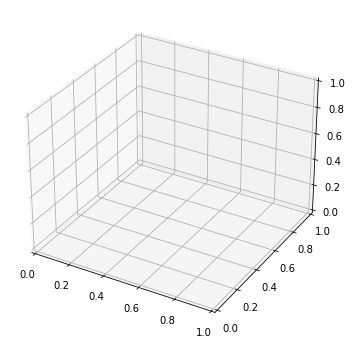

In [28]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
x = np.arange(0, 10, 1)
y = np.arange(0, 10, 1)
x_m, y_m = np.meshgrid(x, y)
x_m = np.reshape(x_m, (10,10,1))
y_m = np.reshape(y_m, (10,10,1))
newxy = np.concatenate((x_m, y_m), axis = 2)
newxy = torch.tensor(newxy, dtype = torch.float32)

newxy = torch.reshape(newxy,(100,2))

z = mybnn(newxy,100)[0]
print(z)

ax.plot_surface(x, y, z, cmap="brg_r")
plt.show()

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

In [ ]:
ax.scatter(x, y, z, color = 'r', alpha = 0.5)